This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import f_oneway as anova
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# set the path to the data
custom_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/custom_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
custom_aggregated_data_pca = pd.read_parquet(custom_aggregated_data_pca_path)
print(custom_aggregated_data_pca.shape)
custom_aggregated_data_pca.head()

(42, 44)


,Metadata_genotype,Metadata_replicate,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,High-Severity,1,-3.551833,1.694277,-1.057982,2.024396,-1.992981,0.695951,-2.506637,2.653554,...,-0.711233,-0.716861,2.068996,0.040072,0.386843,-0.791818,-0.132255,-0.097829,0.111679,-3.330669e-16
1,High-Severity,10,1.827234,9.854972,-3.656266,0.545399,0.556947,-3.294476,2.113450,-3.151756,...,-1.304867,-0.065046,0.669520,1.349892,0.039934,0.822436,-0.111957,0.414218,-0.206628,3.885781e-16
2,High-Severity,11,1.158860,11.349311,-1.585346,1.226329,-0.066575,0.671744,-2.975858,0.621060,...,0.368013,0.326056,-0.263525,-0.587959,0.027409,0.277153,-0.034362,-0.509301,-0.008851,0.000000e+00
3,High-Severity,12,-0.828966,7.901018,-3.988059,0.299961,1.412112,-3.638621,1.544118,0.413128,...,-0.420249,-1.959935,-0.644047,-1.414765,-0.877326,0.228329,0.235810,-1.171712,-0.368368,8.881784e-16
4,High-Severity,13,-1.699153,6.732809,-4.781742,-1.817189,2.407081,-4.115382,-0.429398,3.768067,...,-0.516264,0.301774,-0.060486,1.099896,1.179970,-0.913995,0.457430,0.465218,-0.151247,-4.996004e-16


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA 
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

14 14 14


In [4]:
# drop the the Metadata columns
high_severity = high_severity.drop(columns=["Metadata_genotype", "Metadata_replicate"])
low_severity = low_severity.drop(columns=["Metadata_genotype", "Metadata_replicate"])
wt = wt.drop(columns=["Metadata_genotype", "Metadata_replicate"])
# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(14, 42) (14, 42) (14, 42)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 10.430999188235175


/home/lippincm/miniconda3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 5.312897445636516


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 13.130021647019115


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                                                                                                                                                                                                                 | 0/1000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                                                                        | 1/1000 [00:00<02:17,  7.27it/s]

  0%|▍                                                                                                                                                                                                                        | 2/1000 [00:00<02:21,  7.07it/s]

  0%|▋                                                                                                                                                                                                                        | 3/1000 [00:00<02:31,  6.57it/s]

  0%|▊                                                                                                                                                                                                                        | 4/1000 [00:00<02:30,  6.63it/s]

  0%|█                                                                                                                                                                                                                        | 5/1000 [00:00<02:27,  6.73it/s]

  1%|█▎                                                                                                                                                                                                                       | 6/1000 [00:00<02:26,  6.79it/s]

  1%|█▌                                                                                                                                                                                                                       | 7/1000 [00:01<02:25,  6.83it/s]

  1%|█▋                                                                                                                                                                                                                       | 8/1000 [00:01<02:24,  6.87it/s]

  1%|█▉                                                                                                                                                                                                                       | 9/1000 [00:01<02:23,  6.90it/s]

  1%|██▏                                                                                                                                                                                                                     | 10/1000 [00:01<02:23,  6.91it/s]

  1%|██▍                                                                                                                                                                                                                     | 11/1000 [00:01<02:22,  6.93it/s]

  1%|██▌                                                                                                                                                                                                                     | 12/1000 [00:01<02:23,  6.88it/s]

  1%|██▊                                                                                                                                                                                                                     | 13/1000 [00:01<02:22,  6.90it/s]

  1%|███                                                                                                                                                                                                                     | 14/1000 [00:02<02:22,  6.92it/s]

  2%|███▏                                                                                                                                                                                                                    | 15/1000 [00:02<02:22,  6.93it/s]

  2%|███▍                                                                                                                                                                                                                    | 16/1000 [00:02<02:21,  6.93it/s]

  2%|███▋                                                                                                                                                                                                                    | 17/1000 [00:02<02:21,  6.94it/s]

  2%|███▉                                                                                                                                                                                                                    | 18/1000 [00:02<02:21,  6.93it/s]

  2%|████                                                                                                                                                                                                                    | 19/1000 [00:02<02:21,  6.94it/s]

  2%|████▎                                                                                                                                                                                                                   | 20/1000 [00:02<02:21,  6.92it/s]

  2%|████▌                                                                                                                                                                                                                   | 21/1000 [00:03<02:21,  6.92it/s]

  2%|████▊                                                                                                                                                                                                                   | 22/1000 [00:03<02:21,  6.92it/s]

  2%|████▉                                                                                                                                                                                                                   | 23/1000 [00:03<02:21,  6.93it/s]

  2%|█████▏                                                                                                                                                                                                                  | 24/1000 [00:03<02:20,  6.93it/s]

  2%|█████▍                                                                                                                                                                                                                  | 25/1000 [00:03<02:20,  6.94it/s]

  3%|█████▌                                                                                                                                                                                                                  | 26/1000 [00:03<02:20,  6.92it/s]

  3%|█████▊                                                                                                                                                                                                                  | 27/1000 [00:03<02:20,  6.93it/s]

  3%|██████                                                                                                                                                                                                                  | 28/1000 [00:04<02:20,  6.92it/s]

  3%|██████▎                                                                                                                                                                                                                 | 29/1000 [00:04<02:20,  6.92it/s]

  3%|██████▍                                                                                                                                                                                                                 | 30/1000 [00:04<02:20,  6.91it/s]

  3%|██████▋                                                                                                                                                                                                                 | 31/1000 [00:04<02:20,  6.92it/s]

  3%|██████▉                                                                                                                                                                                                                 | 32/1000 [00:04<02:19,  6.92it/s]

  3%|███████▏                                                                                                                                                                                                                | 33/1000 [00:04<02:19,  6.92it/s]

  3%|███████▎                                                                                                                                                                                                                | 34/1000 [00:04<02:20,  6.89it/s]

  4%|███████▌                                                                                                                                                                                                                | 35/1000 [00:05<02:19,  6.91it/s]

  4%|███████▊                                                                                                                                                                                                                | 36/1000 [00:05<02:19,  6.91it/s]

  4%|███████▉                                                                                                                                                                                                                | 37/1000 [00:05<02:19,  6.92it/s]

  4%|████████▏                                                                                                                                                                                                               | 38/1000 [00:05<02:18,  6.92it/s]

  4%|████████▍                                                                                                                                                                                                               | 39/1000 [00:05<02:18,  6.93it/s]

  4%|████████▋                                                                                                                                                                                                               | 40/1000 [00:05<02:18,  6.94it/s]

  4%|████████▊                                                                                                                                                                                                               | 41/1000 [00:05<02:18,  6.94it/s]

  4%|█████████                                                                                                                                                                                                               | 42/1000 [00:06<02:17,  6.94it/s]

  4%|█████████▎                                                                                                                                                                                                              | 43/1000 [00:06<02:17,  6.95it/s]

  4%|█████████▌                                                                                                                                                                                                              | 44/1000 [00:06<02:17,  6.94it/s]

  4%|█████████▋                                                                                                                                                                                                              | 45/1000 [00:06<02:17,  6.94it/s]

  5%|█████████▉                                                                                                                                                                                                              | 46/1000 [00:06<02:17,  6.94it/s]

  5%|██████████▏                                                                                                                                                                                                             | 47/1000 [00:06<02:17,  6.95it/s]

  5%|██████████▎                                                                                                                                                                                                             | 48/1000 [00:06<02:17,  6.94it/s]

  5%|██████████▌                                                                                                                                                                                                             | 49/1000 [00:07<02:16,  6.95it/s]

  5%|██████████▊                                                                                                                                                                                                             | 50/1000 [00:07<02:16,  6.95it/s]

  5%|███████████                                                                                                                                                                                                             | 51/1000 [00:07<02:16,  6.95it/s]

  5%|███████████▏                                                                                                                                                                                                            | 52/1000 [00:07<02:16,  6.94it/s]

  5%|███████████▍                                                                                                                                                                                                            | 53/1000 [00:07<02:16,  6.95it/s]

  5%|███████████▋                                                                                                                                                                                                            | 54/1000 [00:07<02:16,  6.94it/s]

  6%|███████████▉                                                                                                                                                                                                            | 55/1000 [00:07<02:16,  6.94it/s]

  6%|████████████                                                                                                                                                                                                            | 56/1000 [00:08<02:16,  6.94it/s]

  6%|████████████▎                                                                                                                                                                                                           | 57/1000 [00:08<02:15,  6.94it/s]

  6%|████████████▌                                                                                                                                                                                                           | 58/1000 [00:08<02:15,  6.94it/s]

  6%|████████████▋                                                                                                                                                                                                           | 59/1000 [00:08<02:15,  6.94it/s]

  6%|████████████▉                                                                                                                                                                                                           | 60/1000 [00:08<02:15,  6.94it/s]

  6%|█████████████▏                                                                                                                                                                                                          | 61/1000 [00:08<02:15,  6.94it/s]

  6%|█████████████▍                                                                                                                                                                                                          | 62/1000 [00:08<02:15,  6.93it/s]

  6%|█████████████▌                                                                                                                                                                                                          | 63/1000 [00:09<02:15,  6.93it/s]

  6%|█████████████▊                                                                                                                                                                                                          | 64/1000 [00:09<02:15,  6.93it/s]

  6%|██████████████                                                                                                                                                                                                          | 65/1000 [00:09<02:14,  6.93it/s]

  7%|██████████████▎                                                                                                                                                                                                         | 66/1000 [00:09<02:15,  6.91it/s]

  7%|██████████████▍                                                                                                                                                                                                         | 67/1000 [00:09<02:14,  6.92it/s]

  7%|██████████████▋                                                                                                                                                                                                         | 68/1000 [00:09<02:14,  6.92it/s]

  7%|██████████████▉                                                                                                                                                                                                         | 69/1000 [00:09<02:14,  6.93it/s]

  7%|███████████████                                                                                                                                                                                                         | 70/1000 [00:10<02:14,  6.93it/s]

  7%|███████████████▎                                                                                                                                                                                                        | 71/1000 [00:10<02:14,  6.92it/s]

  7%|███████████████▌                                                                                                                                                                                                        | 72/1000 [00:10<02:14,  6.93it/s]

  7%|███████████████▊                                                                                                                                                                                                        | 73/1000 [00:10<02:13,  6.93it/s]

  7%|███████████████▉                                                                                                                                                                                                        | 74/1000 [00:10<02:13,  6.92it/s]

  8%|████████████████▏                                                                                                                                                                                                       | 75/1000 [00:10<02:13,  6.91it/s]

  8%|████████████████▍                                                                                                                                                                                                       | 76/1000 [00:10<02:13,  6.91it/s]

  8%|████████████████▋                                                                                                                                                                                                       | 77/1000 [00:11<02:13,  6.91it/s]

  8%|████████████████▊                                                                                                                                                                                                       | 78/1000 [00:11<02:13,  6.91it/s]

  8%|█████████████████                                                                                                                                                                                                       | 79/1000 [00:11<02:13,  6.92it/s]

  8%|█████████████████▎                                                                                                                                                                                                      | 80/1000 [00:11<02:13,  6.92it/s]

  8%|█████████████████▍                                                                                                                                                                                                      | 81/1000 [00:11<02:12,  6.92it/s]

  8%|█████████████████▋                                                                                                                                                                                                      | 82/1000 [00:11<02:13,  6.86it/s]

  8%|█████████████████▉                                                                                                                                                                                                      | 83/1000 [00:12<02:14,  6.82it/s]

  8%|██████████████████▏                                                                                                                                                                                                     | 84/1000 [00:12<02:18,  6.62it/s]

  8%|██████████████████▎                                                                                                                                                                                                     | 85/1000 [00:12<02:16,  6.68it/s]

  9%|██████████████████▌                                                                                                                                                                                                     | 86/1000 [00:12<02:15,  6.76it/s]

  9%|██████████████████▊                                                                                                                                                                                                     | 87/1000 [00:12<02:14,  6.80it/s]

  9%|███████████████████                                                                                                                                                                                                     | 88/1000 [00:12<02:13,  6.83it/s]

  9%|███████████████████▏                                                                                                                                                                                                    | 89/1000 [00:12<02:12,  6.86it/s]

  9%|███████████████████▍                                                                                                                                                                                                    | 90/1000 [00:13<02:12,  6.88it/s]

  9%|███████████████████▋                                                                                                                                                                                                    | 91/1000 [00:13<02:11,  6.89it/s]

  9%|███████████████████▊                                                                                                                                                                                                    | 92/1000 [00:13<02:11,  6.91it/s]

  9%|████████████████████                                                                                                                                                                                                    | 93/1000 [00:13<02:11,  6.91it/s]

  9%|████████████████████▎                                                                                                                                                                                                   | 94/1000 [00:13<02:10,  6.92it/s]

 10%|████████████████████▌                                                                                                                                                                                                   | 95/1000 [00:13<02:10,  6.93it/s]

 10%|████████████████████▋                                                                                                                                                                                                   | 96/1000 [00:13<02:10,  6.93it/s]

 10%|████████████████████▉                                                                                                                                                                                                   | 97/1000 [00:14<02:10,  6.94it/s]

 10%|█████████████████████▏                                                                                                                                                                                                  | 98/1000 [00:14<02:09,  6.94it/s]

 10%|█████████████████████▍                                                                                                                                                                                                  | 99/1000 [00:14<02:11,  6.85it/s]

 10%|█████████████████████▌                                                                                                                                                                                                 | 100/1000 [00:14<02:16,  6.60it/s]

 10%|█████████████████████▋                                                                                                                                                                                                 | 101/1000 [00:14<02:15,  6.65it/s]

 10%|█████████████████████▉                                                                                                                                                                                                 | 102/1000 [00:14<02:13,  6.73it/s]

 10%|██████████████████████▏                                                                                                                                                                                                | 103/1000 [00:14<02:12,  6.79it/s]

 10%|██████████████████████▎                                                                                                                                                                                                | 104/1000 [00:15<02:11,  6.82it/s]

 10%|██████████████████████▌                                                                                                                                                                                                | 105/1000 [00:15<02:10,  6.85it/s]

 11%|██████████████████████▊                                                                                                                                                                                                | 106/1000 [00:15<02:10,  6.86it/s]

 11%|███████████████████████                                                                                                                                                                                                | 107/1000 [00:15<02:09,  6.88it/s]

 11%|███████████████████████▏                                                                                                                                                                                               | 108/1000 [00:15<02:09,  6.89it/s]

 11%|███████████████████████▍                                                                                                                                                                                               | 109/1000 [00:15<02:09,  6.90it/s]

 11%|███████████████████████▋                                                                                                                                                                                               | 110/1000 [00:15<02:08,  6.90it/s]

 11%|███████████████████████▊                                                                                                                                                                                               | 111/1000 [00:16<02:08,  6.91it/s]

 11%|████████████████████████                                                                                                                                                                                               | 112/1000 [00:16<02:08,  6.92it/s]

 11%|████████████████████████▎                                                                                                                                                                                              | 113/1000 [00:16<02:08,  6.92it/s]

 11%|████████████████████████▌                                                                                                                                                                                              | 114/1000 [00:16<02:07,  6.92it/s]

 12%|████████████████████████▋                                                                                                                                                                                              | 115/1000 [00:16<02:07,  6.93it/s]

 12%|████████████████████████▉                                                                                                                                                                                              | 116/1000 [00:16<02:07,  6.93it/s]

 12%|█████████████████████████▏                                                                                                                                                                                             | 117/1000 [00:16<02:07,  6.93it/s]

 12%|█████████████████████████▎                                                                                                                                                                                             | 118/1000 [00:17<02:07,  6.92it/s]

 12%|█████████████████████████▌                                                                                                                                                                                             | 119/1000 [00:17<02:07,  6.93it/s]

 12%|█████████████████████████▊                                                                                                                                                                                             | 120/1000 [00:17<02:07,  6.91it/s]

 12%|██████████████████████████                                                                                                                                                                                             | 121/1000 [00:17<02:07,  6.91it/s]

 12%|██████████████████████████▏                                                                                                                                                                                            | 122/1000 [00:17<02:06,  6.92it/s]

 12%|██████████████████████████▍                                                                                                                                                                                            | 123/1000 [00:17<02:06,  6.92it/s]

 12%|██████████████████████████▋                                                                                                                                                                                            | 124/1000 [00:17<02:06,  6.92it/s]

 12%|██████████████████████████▉                                                                                                                                                                                            | 125/1000 [00:18<02:06,  6.92it/s]

 13%|███████████████████████████                                                                                                                                                                                            | 126/1000 [00:18<02:06,  6.93it/s]

 13%|███████████████████████████▎                                                                                                                                                                                           | 127/1000 [00:18<02:05,  6.93it/s]

 13%|███████████████████████████▌                                                                                                                                                                                           | 128/1000 [00:18<02:06,  6.90it/s]

 13%|███████████████████████████▋                                                                                                                                                                                           | 129/1000 [00:18<02:06,  6.91it/s]

 13%|███████████████████████████▉                                                                                                                                                                                           | 130/1000 [00:18<02:05,  6.91it/s]

 13%|████████████████████████████▏                                                                                                                                                                                          | 131/1000 [00:18<02:05,  6.92it/s]

 13%|████████████████████████████▍                                                                                                                                                                                          | 132/1000 [00:19<02:07,  6.82it/s]

 13%|████████████████████████████▌                                                                                                                                                                                          | 133/1000 [00:19<02:32,  5.69it/s]

 13%|████████████████████████████▊                                                                                                                                                                                          | 134/1000 [00:19<02:30,  5.75it/s]

 14%|█████████████████████████████                                                                                                                                                                                          | 135/1000 [00:19<02:22,  6.05it/s]

 14%|█████████████████████████████▏                                                                                                                                                                                         | 136/1000 [00:19<02:17,  6.30it/s]

 14%|█████████████████████████████▍                                                                                                                                                                                         | 137/1000 [00:19<02:13,  6.48it/s]

 14%|█████████████████████████████▋                                                                                                                                                                                         | 138/1000 [00:20<02:10,  6.61it/s]

 14%|█████████████████████████████▉                                                                                                                                                                                         | 139/1000 [00:20<02:08,  6.71it/s]

 14%|██████████████████████████████                                                                                                                                                                                         | 140/1000 [00:20<02:06,  6.78it/s]

 14%|██████████████████████████████▎                                                                                                                                                                                        | 141/1000 [00:20<02:05,  6.83it/s]

 14%|██████████████████████████████▌                                                                                                                                                                                        | 142/1000 [00:20<02:05,  6.86it/s]

 14%|██████████████████████████████▋                                                                                                                                                                                        | 143/1000 [00:20<02:04,  6.89it/s]

 14%|██████████████████████████████▉                                                                                                                                                                                        | 144/1000 [00:20<02:03,  6.90it/s]

 14%|███████████████████████████████▏                                                                                                                                                                                       | 145/1000 [00:21<02:03,  6.92it/s]

 15%|███████████████████████████████▍                                                                                                                                                                                       | 146/1000 [00:21<02:03,  6.93it/s]

 15%|███████████████████████████████▌                                                                                                                                                                                       | 147/1000 [00:21<02:03,  6.93it/s]

 15%|███████████████████████████████▊                                                                                                                                                                                       | 148/1000 [00:21<02:02,  6.93it/s]

 15%|████████████████████████████████                                                                                                                                                                                       | 149/1000 [00:21<02:02,  6.93it/s]

 15%|████████████████████████████████▎                                                                                                                                                                                      | 150/1000 [00:21<02:02,  6.93it/s]

 15%|████████████████████████████████▍                                                                                                                                                                                      | 151/1000 [00:22<02:02,  6.94it/s]

 15%|████████████████████████████████▋                                                                                                                                                                                      | 152/1000 [00:22<02:02,  6.94it/s]

 15%|████████████████████████████████▉                                                                                                                                                                                      | 153/1000 [00:22<02:01,  6.94it/s]

 15%|█████████████████████████████████                                                                                                                                                                                      | 154/1000 [00:22<02:01,  6.94it/s]

 16%|█████████████████████████████████▎                                                                                                                                                                                     | 155/1000 [00:22<02:01,  6.94it/s]

 16%|█████████████████████████████████▌                                                                                                                                                                                     | 156/1000 [00:22<02:01,  6.94it/s]

 16%|█████████████████████████████████▊                                                                                                                                                                                     | 157/1000 [00:22<02:01,  6.94it/s]

 16%|█████████████████████████████████▉                                                                                                                                                                                     | 158/1000 [00:23<02:01,  6.94it/s]

 16%|██████████████████████████████████▏                                                                                                                                                                                    | 159/1000 [00:23<02:01,  6.95it/s]

 16%|██████████████████████████████████▍                                                                                                                                                                                    | 160/1000 [00:23<02:01,  6.94it/s]

 16%|██████████████████████████████████▌                                                                                                                                                                                    | 161/1000 [00:23<02:00,  6.94it/s]

 16%|██████████████████████████████████▊                                                                                                                                                                                    | 162/1000 [00:23<02:00,  6.93it/s]

 16%|███████████████████████████████████                                                                                                                                                                                    | 163/1000 [00:23<02:00,  6.94it/s]

 16%|███████████████████████████████████▎                                                                                                                                                                                   | 164/1000 [00:23<02:00,  6.93it/s]

 16%|███████████████████████████████████▍                                                                                                                                                                                   | 165/1000 [00:24<02:00,  6.94it/s]

 17%|███████████████████████████████████▋                                                                                                                                                                                   | 166/1000 [00:24<02:00,  6.94it/s]

 17%|███████████████████████████████████▉                                                                                                                                                                                   | 167/1000 [00:24<01:59,  6.94it/s]

 17%|████████████████████████████████████                                                                                                                                                                                   | 168/1000 [00:24<01:59,  6.93it/s]

 17%|████████████████████████████████████▎                                                                                                                                                                                  | 169/1000 [00:24<01:59,  6.94it/s]

 17%|████████████████████████████████████▌                                                                                                                                                                                  | 170/1000 [00:24<01:59,  6.93it/s]

 17%|████████████████████████████████████▊                                                                                                                                                                                  | 171/1000 [00:24<01:59,  6.92it/s]

 17%|████████████████████████████████████▉                                                                                                                                                                                  | 172/1000 [00:25<01:59,  6.92it/s]

 17%|█████████████████████████████████████▏                                                                                                                                                                                 | 173/1000 [00:25<01:59,  6.93it/s]

 17%|█████████████████████████████████████▍                                                                                                                                                                                 | 174/1000 [00:25<01:59,  6.94it/s]

 18%|█████████████████████████████████████▋                                                                                                                                                                                 | 175/1000 [00:25<01:58,  6.94it/s]

 18%|█████████████████████████████████████▊                                                                                                                                                                                 | 176/1000 [00:25<01:58,  6.93it/s]

 18%|██████████████████████████████████████                                                                                                                                                                                 | 177/1000 [00:25<01:58,  6.94it/s]

 18%|██████████████████████████████████████▎                                                                                                                                                                                | 178/1000 [00:25<01:58,  6.94it/s]

 18%|██████████████████████████████████████▍                                                                                                                                                                                | 179/1000 [00:26<01:58,  6.95it/s]

 18%|██████████████████████████████████████▋                                                                                                                                                                                | 180/1000 [00:26<01:58,  6.94it/s]

 18%|██████████████████████████████████████▉                                                                                                                                                                                | 181/1000 [00:26<01:57,  6.95it/s]

 18%|███████████████████████████████████████▏                                                                                                                                                                               | 182/1000 [00:26<01:57,  6.94it/s]

 18%|███████████████████████████████████████▎                                                                                                                                                                               | 183/1000 [00:26<01:57,  6.95it/s]

 18%|███████████████████████████████████████▌                                                                                                                                                                               | 184/1000 [00:26<01:57,  6.94it/s]

 18%|███████████████████████████████████████▊                                                                                                                                                                               | 185/1000 [00:26<01:57,  6.94it/s]

 19%|███████████████████████████████████████▉                                                                                                                                                                               | 186/1000 [00:27<01:57,  6.94it/s]

 19%|████████████████████████████████████████▏                                                                                                                                                                              | 187/1000 [00:27<01:57,  6.94it/s]

 19%|████████████████████████████████████████▍                                                                                                                                                                              | 188/1000 [00:27<01:57,  6.94it/s]

 19%|████████████████████████████████████████▋                                                                                                                                                                              | 189/1000 [00:27<01:56,  6.94it/s]

 19%|████████████████████████████████████████▊                                                                                                                                                                              | 190/1000 [00:27<01:56,  6.94it/s]

 19%|█████████████████████████████████████████                                                                                                                                                                              | 191/1000 [00:27<01:56,  6.95it/s]

 19%|█████████████████████████████████████████▎                                                                                                                                                                             | 192/1000 [00:27<01:56,  6.93it/s]

 19%|█████████████████████████████████████████▍                                                                                                                                                                             | 193/1000 [00:28<01:56,  6.93it/s]

 19%|█████████████████████████████████████████▋                                                                                                                                                                             | 194/1000 [00:28<01:56,  6.93it/s]

 20%|█████████████████████████████████████████▉                                                                                                                                                                             | 195/1000 [00:28<01:56,  6.91it/s]

 20%|██████████████████████████████████████████▏                                                                                                                                                                            | 196/1000 [00:28<01:56,  6.92it/s]

 20%|██████████████████████████████████████████▎                                                                                                                                                                            | 197/1000 [00:28<01:55,  6.93it/s]

 20%|██████████████████████████████████████████▌                                                                                                                                                                            | 198/1000 [00:28<01:55,  6.93it/s]

 20%|██████████████████████████████████████████▊                                                                                                                                                                            | 199/1000 [00:28<01:55,  6.92it/s]

 20%|███████████████████████████████████████████                                                                                                                                                                            | 200/1000 [00:29<01:55,  6.90it/s]

 20%|███████████████████████████████████████████▏                                                                                                                                                                           | 201/1000 [00:29<01:55,  6.89it/s]

 20%|███████████████████████████████████████████▍                                                                                                                                                                           | 202/1000 [00:29<01:55,  6.90it/s]

 20%|███████████████████████████████████████████▋                                                                                                                                                                           | 203/1000 [00:29<01:55,  6.90it/s]

 20%|███████████████████████████████████████████▊                                                                                                                                                                           | 204/1000 [00:29<01:55,  6.91it/s]

 20%|████████████████████████████████████████████                                                                                                                                                                           | 205/1000 [00:29<01:54,  6.92it/s]

 21%|████████████████████████████████████████████▎                                                                                                                                                                          | 206/1000 [00:29<01:54,  6.92it/s]

 21%|████████████████████████████████████████████▌                                                                                                                                                                          | 207/1000 [00:30<01:54,  6.93it/s]

 21%|████████████████████████████████████████████▋                                                                                                                                                                          | 208/1000 [00:30<01:57,  6.73it/s]

 21%|████████████████████████████████████████████▉                                                                                                                                                                          | 209/1000 [00:30<01:56,  6.80it/s]

 21%|█████████████████████████████████████████████▏                                                                                                                                                                         | 210/1000 [00:30<01:56,  6.80it/s]

 21%|█████████████████████████████████████████████▎                                                                                                                                                                         | 211/1000 [00:30<01:56,  6.79it/s]

 21%|█████████████████████████████████████████████▌                                                                                                                                                                         | 212/1000 [00:30<01:55,  6.84it/s]

 21%|█████████████████████████████████████████████▊                                                                                                                                                                         | 213/1000 [00:30<01:55,  6.80it/s]

 21%|██████████████████████████████████████████████                                                                                                                                                                         | 214/1000 [00:31<01:55,  6.81it/s]

 22%|██████████████████████████████████████████████▏                                                                                                                                                                        | 215/1000 [00:31<01:54,  6.84it/s]

 22%|██████████████████████████████████████████████▍                                                                                                                                                                        | 216/1000 [00:31<01:55,  6.79it/s]

 22%|██████████████████████████████████████████████▋                                                                                                                                                                        | 217/1000 [00:31<01:56,  6.74it/s]

 22%|██████████████████████████████████████████████▊                                                                                                                                                                        | 218/1000 [00:31<01:56,  6.72it/s]

 22%|███████████████████████████████████████████████                                                                                                                                                                        | 219/1000 [00:31<01:56,  6.68it/s]

 22%|███████████████████████████████████████████████▎                                                                                                                                                                       | 220/1000 [00:32<01:57,  6.63it/s]

 22%|███████████████████████████████████████████████▌                                                                                                                                                                       | 221/1000 [00:32<02:00,  6.44it/s]

 22%|███████████████████████████████████████████████▋                                                                                                                                                                       | 222/1000 [00:32<02:00,  6.48it/s]

 22%|███████████████████████████████████████████████▉                                                                                                                                                                       | 223/1000 [00:32<02:03,  6.31it/s]

 22%|████████████████████████████████████████████████▏                                                                                                                                                                      | 224/1000 [00:32<01:59,  6.49it/s]

 22%|████████████████████████████████████████████████▍                                                                                                                                                                      | 225/1000 [00:32<01:57,  6.62it/s]

 23%|████████████████████████████████████████████████▌                                                                                                                                                                      | 226/1000 [00:32<01:55,  6.72it/s]

 23%|████████████████████████████████████████████████▊                                                                                                                                                                      | 227/1000 [00:33<01:54,  6.77it/s]

 23%|█████████████████████████████████████████████████                                                                                                                                                                      | 228/1000 [00:33<01:53,  6.83it/s]

 23%|█████████████████████████████████████████████████▏                                                                                                                                                                     | 229/1000 [00:33<01:52,  6.87it/s]

 23%|█████████████████████████████████████████████████▍                                                                                                                                                                     | 230/1000 [00:33<01:51,  6.91it/s]

 23%|█████████████████████████████████████████████████▋                                                                                                                                                                     | 231/1000 [00:33<01:50,  6.94it/s]

 23%|█████████████████████████████████████████████████▉                                                                                                                                                                     | 232/1000 [00:33<01:51,  6.88it/s]

 23%|██████████████████████████████████████████████████                                                                                                                                                                     | 233/1000 [00:33<01:52,  6.84it/s]

 23%|██████████████████████████████████████████████████▎                                                                                                                                                                    | 234/1000 [00:34<01:54,  6.70it/s]

 24%|██████████████████████████████████████████████████▌                                                                                                                                                                    | 235/1000 [00:34<01:53,  6.71it/s]

 24%|██████████████████████████████████████████████████▋                                                                                                                                                                    | 236/1000 [00:34<01:52,  6.78it/s]

 24%|██████████████████████████████████████████████████▉                                                                                                                                                                    | 237/1000 [00:34<01:53,  6.70it/s]

 24%|███████████████████████████████████████████████████▏                                                                                                                                                                   | 238/1000 [00:34<01:56,  6.53it/s]

 24%|███████████████████████████████████████████████████▍                                                                                                                                                                   | 239/1000 [00:34<01:54,  6.66it/s]

 24%|███████████████████████████████████████████████████▌                                                                                                                                                                   | 240/1000 [00:35<01:53,  6.68it/s]

 24%|███████████████████████████████████████████████████▊                                                                                                                                                                   | 241/1000 [00:35<01:53,  6.71it/s]

 24%|████████████████████████████████████████████████████                                                                                                                                                                   | 242/1000 [00:35<01:51,  6.79it/s]

 24%|████████████████████████████████████████████████████▏                                                                                                                                                                  | 243/1000 [00:35<01:50,  6.85it/s]

 24%|████████████████████████████████████████████████████▍                                                                                                                                                                  | 244/1000 [00:35<01:49,  6.89it/s]

 24%|████████████████████████████████████████████████████▋                                                                                                                                                                  | 245/1000 [00:35<01:49,  6.93it/s]

 25%|████████████████████████████████████████████████████▉                                                                                                                                                                  | 246/1000 [00:35<01:48,  6.95it/s]

 25%|█████████████████████████████████████████████████████                                                                                                                                                                  | 247/1000 [00:36<01:48,  6.96it/s]

 25%|█████████████████████████████████████████████████████▎                                                                                                                                                                 | 248/1000 [00:36<01:48,  6.91it/s]

 25%|█████████████████████████████████████████████████████▌                                                                                                                                                                 | 249/1000 [00:36<01:48,  6.93it/s]

 25%|█████████████████████████████████████████████████████▊                                                                                                                                                                 | 250/1000 [00:36<01:47,  6.95it/s]

 25%|█████████████████████████████████████████████████████▉                                                                                                                                                                 | 251/1000 [00:36<01:47,  6.95it/s]

 25%|██████████████████████████████████████████████████████▏                                                                                                                                                                | 252/1000 [00:36<01:47,  6.96it/s]

 25%|██████████████████████████████████████████████████████▍                                                                                                                                                                | 253/1000 [00:36<01:48,  6.91it/s]

 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                | 254/1000 [00:37<01:50,  6.74it/s]

 26%|██████████████████████████████████████████████████████▊                                                                                                                                                                | 255/1000 [00:37<01:51,  6.70it/s]

 26%|███████████████████████████████████████████████████████                                                                                                                                                                | 256/1000 [00:37<01:57,  6.34it/s]

 26%|███████████████████████████████████████████████████████▎                                                                                                                                                               | 257/1000 [00:37<01:54,  6.49it/s]

 26%|███████████████████████████████████████████████████████▍                                                                                                                                                               | 258/1000 [00:37<01:52,  6.61it/s]

 26%|███████████████████████████████████████████████████████▋                                                                                                                                                               | 259/1000 [00:37<01:50,  6.71it/s]

 26%|███████████████████████████████████████████████████████▉                                                                                                                                                               | 260/1000 [00:37<01:49,  6.77it/s]

 26%|████████████████████████████████████████████████████████                                                                                                                                                               | 261/1000 [00:38<01:48,  6.81it/s]

 26%|████████████████████████████████████████████████████████▎                                                                                                                                                              | 262/1000 [00:38<01:47,  6.85it/s]

 26%|████████████████████████████████████████████████████████▌                                                                                                                                                              | 263/1000 [00:38<01:47,  6.87it/s]

 26%|████████████████████████████████████████████████████████▊                                                                                                                                                              | 264/1000 [00:38<01:47,  6.83it/s]

 26%|████████████████████████████████████████████████████████▉                                                                                                                                                              | 265/1000 [00:38<01:47,  6.85it/s]

 27%|█████████████████████████████████████████████████████████▏                                                                                                                                                             | 266/1000 [00:38<01:47,  6.81it/s]

 27%|█████████████████████████████████████████████████████████▍                                                                                                                                                             | 267/1000 [00:38<01:47,  6.81it/s]

 27%|█████████████████████████████████████████████████████████▌                                                                                                                                                             | 268/1000 [00:39<01:46,  6.84it/s]

 27%|█████████████████████████████████████████████████████████▊                                                                                                                                                             | 269/1000 [00:39<01:46,  6.87it/s]

 27%|██████████████████████████████████████████████████████████                                                                                                                                                             | 270/1000 [00:39<01:46,  6.83it/s]

 27%|██████████████████████████████████████████████████████████▎                                                                                                                                                            | 271/1000 [00:39<01:47,  6.76it/s]

 27%|██████████████████████████████████████████████████████████▍                                                                                                                                                            | 272/1000 [00:39<01:47,  6.80it/s]

 27%|██████████████████████████████████████████████████████████▋                                                                                                                                                            | 273/1000 [00:39<01:46,  6.84it/s]

 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                            | 274/1000 [00:39<01:46,  6.82it/s]

 28%|███████████████████████████████████████████████████████████▏                                                                                                                                                           | 275/1000 [00:40<01:46,  6.78it/s]

 28%|███████████████████████████████████████████████████████████▎                                                                                                                                                           | 276/1000 [00:40<01:46,  6.82it/s]

 28%|███████████████████████████████████████████████████████████▌                                                                                                                                                           | 277/1000 [00:40<01:45,  6.86it/s]

 28%|███████████████████████████████████████████████████████████▊                                                                                                                                                           | 278/1000 [00:40<01:45,  6.86it/s]

 28%|███████████████████████████████████████████████████████████▉                                                                                                                                                           | 279/1000 [00:40<01:44,  6.89it/s]

 28%|████████████████████████████████████████████████████████████▏                                                                                                                                                          | 280/1000 [00:40<01:44,  6.88it/s]

 28%|████████████████████████████████████████████████████████████▍                                                                                                                                                          | 281/1000 [00:41<01:44,  6.88it/s]

 28%|████████████████████████████████████████████████████████████▋                                                                                                                                                          | 282/1000 [00:41<01:44,  6.90it/s]

 28%|████████████████████████████████████████████████████████████▊                                                                                                                                                          | 283/1000 [00:41<01:43,  6.90it/s]

 28%|█████████████████████████████████████████████████████████████                                                                                                                                                          | 284/1000 [00:41<01:43,  6.90it/s]

 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                         | 285/1000 [00:41<01:43,  6.92it/s]

 29%|█████████████████████████████████████████████████████████████▍                                                                                                                                                         | 286/1000 [00:41<01:43,  6.93it/s]

 29%|█████████████████████████████████████████████████████████████▋                                                                                                                                                         | 287/1000 [00:41<01:43,  6.91it/s]

 29%|█████████████████████████████████████████████████████████████▉                                                                                                                                                         | 288/1000 [00:42<01:42,  6.92it/s]

 29%|██████████████████████████████████████████████████████████████▏                                                                                                                                                        | 289/1000 [00:42<01:43,  6.90it/s]

 29%|██████████████████████████████████████████████████████████████▎                                                                                                                                                        | 290/1000 [00:42<01:42,  6.90it/s]

 29%|██████████████████████████████████████████████████████████████▌                                                                                                                                                        | 291/1000 [00:42<01:44,  6.79it/s]

 29%|██████████████████████████████████████████████████████████████▊                                                                                                                                                        | 292/1000 [00:42<01:44,  6.80it/s]

 29%|██████████████████████████████████████████████████████████████▉                                                                                                                                                        | 293/1000 [00:42<01:43,  6.85it/s]

 29%|███████████████████████████████████████████████████████████████▏                                                                                                                                                       | 294/1000 [00:42<01:42,  6.88it/s]

 30%|███████████████████████████████████████████████████████████████▍                                                                                                                                                       | 295/1000 [00:43<01:42,  6.88it/s]

 30%|███████████████████████████████████████████████████████████████▋                                                                                                                                                       | 296/1000 [00:43<01:42,  6.89it/s]

 30%|███████████████████████████████████████████████████████████████▊                                                                                                                                                       | 297/1000 [00:43<01:41,  6.91it/s]

 30%|████████████████████████████████████████████████████████████████                                                                                                                                                       | 298/1000 [00:43<01:42,  6.88it/s]

 30%|████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 299/1000 [00:43<01:41,  6.90it/s]

 30%|████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 300/1000 [00:43<01:41,  6.87it/s]

 30%|████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 301/1000 [00:43<01:41,  6.89it/s]

 30%|████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 302/1000 [00:44<01:41,  6.91it/s]

 30%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 303/1000 [00:44<01:40,  6.91it/s]

 30%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 304/1000 [00:44<01:40,  6.92it/s]

 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 305/1000 [00:44<01:40,  6.93it/s]

 31%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 306/1000 [00:44<01:40,  6.90it/s]

 31%|██████████████████████████████████████████████████████████████████                                                                                                                                                     | 307/1000 [00:44<01:40,  6.90it/s]

 31%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 308/1000 [00:44<01:40,  6.91it/s]

 31%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 309/1000 [00:45<01:40,  6.89it/s]

 31%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 310/1000 [00:45<01:39,  6.90it/s]

 31%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 311/1000 [00:45<01:40,  6.83it/s]

 31%|███████████████████████████████████████████████████████████████████                                                                                                                                                    | 312/1000 [00:45<01:40,  6.83it/s]

 31%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 313/1000 [00:45<01:40,  6.87it/s]

 31%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 314/1000 [00:45<01:39,  6.89it/s]

 32%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 315/1000 [00:45<01:39,  6.88it/s]

 32%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 316/1000 [00:46<01:39,  6.90it/s]

 32%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 317/1000 [00:46<01:38,  6.92it/s]

 32%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 318/1000 [00:46<01:38,  6.90it/s]

 32%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 319/1000 [00:46<01:38,  6.88it/s]

 32%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 320/1000 [00:46<01:39,  6.86it/s]

 32%|█████████████████████████████████████████████████████████████████████                                                                                                                                                  | 321/1000 [00:46<01:38,  6.88it/s]

 32%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 322/1000 [00:46<01:38,  6.86it/s]

 32%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 323/1000 [00:47<01:38,  6.89it/s]

 32%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 324/1000 [00:47<01:38,  6.83it/s]

 32%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 325/1000 [00:47<01:38,  6.87it/s]

 33%|██████████████████████████████████████████████████████████████████████                                                                                                                                                 | 326/1000 [00:47<01:37,  6.89it/s]

 33%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 327/1000 [00:47<01:37,  6.91it/s]

 33%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 328/1000 [00:47<01:37,  6.92it/s]

 33%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 329/1000 [00:47<01:36,  6.93it/s]

 33%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 330/1000 [00:48<01:37,  6.89it/s]

 33%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 331/1000 [00:48<01:36,  6.91it/s]

 33%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 332/1000 [00:48<01:36,  6.92it/s]

 33%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 333/1000 [00:48<01:36,  6.90it/s]

 33%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 334/1000 [00:48<01:36,  6.88it/s]

 34%|████████████████████████████████████████████████████████████████████████                                                                                                                                               | 335/1000 [00:48<01:36,  6.87it/s]

 34%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 336/1000 [00:48<01:36,  6.90it/s]

 34%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 337/1000 [00:49<01:35,  6.92it/s]

 34%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 338/1000 [00:49<01:36,  6.86it/s]

 34%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 339/1000 [00:49<01:35,  6.90it/s]

 34%|█████████████████████████████████████████████████████████████████████████                                                                                                                                              | 340/1000 [00:49<01:35,  6.91it/s]

 34%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 341/1000 [00:49<01:35,  6.91it/s]

 34%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 342/1000 [00:49<01:35,  6.91it/s]

 34%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 343/1000 [00:50<01:35,  6.92it/s]

 34%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 344/1000 [00:50<01:35,  6.90it/s]

 34%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 345/1000 [00:50<01:34,  6.91it/s]

 35%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 346/1000 [00:50<01:34,  6.89it/s]

 35%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 347/1000 [00:50<01:34,  6.90it/s]

 35%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 348/1000 [00:50<01:34,  6.91it/s]

 35%|███████████████████████████████████████████████████████████████████████████                                                                                                                                            | 349/1000 [00:50<01:40,  6.45it/s]

 35%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 350/1000 [00:51<01:38,  6.62it/s]

 35%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 351/1000 [00:51<01:36,  6.71it/s]

 35%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 352/1000 [00:51<01:36,  6.73it/s]

 35%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 353/1000 [00:51<01:35,  6.79it/s]

 35%|████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 354/1000 [00:51<01:38,  6.56it/s]

 36%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 355/1000 [00:51<01:36,  6.66it/s]

 36%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 356/1000 [00:51<01:35,  6.71it/s]

 36%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 357/1000 [00:52<01:35,  6.76it/s]

 36%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 358/1000 [00:52<01:34,  6.78it/s]

 36%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 359/1000 [00:52<01:33,  6.83it/s]

 36%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 360/1000 [00:52<01:33,  6.86it/s]

 36%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 361/1000 [00:52<01:33,  6.81it/s]

 36%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 362/1000 [00:52<01:33,  6.82it/s]

 36%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 363/1000 [00:52<01:32,  6.86it/s]

 36%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 364/1000 [00:53<01:32,  6.89it/s]

 36%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 365/1000 [00:53<01:32,  6.88it/s]

 37%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 366/1000 [00:53<01:32,  6.89it/s]

 37%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 367/1000 [00:53<01:31,  6.90it/s]

 37%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 368/1000 [00:53<01:31,  6.91it/s]

 37%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 369/1000 [00:53<01:31,  6.93it/s]

 37%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 370/1000 [00:53<01:30,  6.93it/s]

 37%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 371/1000 [00:54<01:31,  6.90it/s]

 37%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 372/1000 [00:54<01:30,  6.90it/s]

 37%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 373/1000 [00:54<01:30,  6.91it/s]

 37%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 374/1000 [00:54<01:30,  6.89it/s]

 38%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 375/1000 [00:54<01:30,  6.90it/s]

 38%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 376/1000 [00:54<01:30,  6.91it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 377/1000 [00:54<01:30,  6.92it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 378/1000 [00:55<01:29,  6.92it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 379/1000 [00:55<01:29,  6.93it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 380/1000 [00:55<01:29,  6.90it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 381/1000 [00:55<01:30,  6.83it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 382/1000 [00:55<01:30,  6.86it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 383/1000 [00:55<01:29,  6.87it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 384/1000 [00:56<01:29,  6.88it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 385/1000 [00:56<01:29,  6.90it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 386/1000 [00:56<01:28,  6.90it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 387/1000 [00:56<01:33,  6.54it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 388/1000 [00:56<01:31,  6.68it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 389/1000 [00:56<01:31,  6.71it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 390/1000 [00:56<01:29,  6.79it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 391/1000 [00:57<01:29,  6.84it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 392/1000 [00:57<01:28,  6.85it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 393/1000 [00:57<01:29,  6.81it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 394/1000 [00:57<01:28,  6.81it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 395/1000 [00:57<01:28,  6.84it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 396/1000 [00:57<01:27,  6.87it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 397/1000 [00:57<01:27,  6.89it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 398/1000 [00:58<01:27,  6.91it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 399/1000 [00:58<01:26,  6.92it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 400/1000 [00:58<01:26,  6.92it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 401/1000 [00:58<01:26,  6.93it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 402/1000 [00:58<01:26,  6.94it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 403/1000 [00:58<01:26,  6.94it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 404/1000 [00:58<01:25,  6.94it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 405/1000 [00:59<01:25,  6.94it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 406/1000 [00:59<01:25,  6.94it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 407/1000 [00:59<01:25,  6.94it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 408/1000 [00:59<01:25,  6.94it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 409/1000 [00:59<01:25,  6.95it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 410/1000 [00:59<01:24,  6.94it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 411/1000 [00:59<01:24,  6.94it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 412/1000 [01:00<01:24,  6.94it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 413/1000 [01:00<01:24,  6.94it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 414/1000 [01:00<01:24,  6.93it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 415/1000 [01:00<01:24,  6.92it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 416/1000 [01:00<01:24,  6.92it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 417/1000 [01:00<01:24,  6.93it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 418/1000 [01:00<01:24,  6.92it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 419/1000 [01:01<01:23,  6.92it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 420/1000 [01:01<01:23,  6.92it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 421/1000 [01:01<01:23,  6.92it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 422/1000 [01:01<01:24,  6.86it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 423/1000 [01:01<01:23,  6.89it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 424/1000 [01:01<01:23,  6.91it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 425/1000 [01:01<01:23,  6.92it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 426/1000 [01:02<01:22,  6.92it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 427/1000 [01:02<01:22,  6.93it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 428/1000 [01:02<01:22,  6.93it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 429/1000 [01:02<01:22,  6.93it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 430/1000 [01:02<01:22,  6.93it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 431/1000 [01:02<01:22,  6.94it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 432/1000 [01:02<01:21,  6.94it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 433/1000 [01:03<01:21,  6.94it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 434/1000 [01:03<01:21,  6.94it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 435/1000 [01:03<01:21,  6.94it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 436/1000 [01:03<01:21,  6.94it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 437/1000 [01:03<01:21,  6.95it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 438/1000 [01:03<01:20,  6.94it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 439/1000 [01:03<01:20,  6.94it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 440/1000 [01:04<01:20,  6.93it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 441/1000 [01:04<01:20,  6.94it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 442/1000 [01:04<01:20,  6.94it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 443/1000 [01:04<01:20,  6.93it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 444/1000 [01:04<01:20,  6.93it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 445/1000 [01:04<01:20,  6.93it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 446/1000 [01:04<01:19,  6.93it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 447/1000 [01:05<01:19,  6.93it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 448/1000 [01:05<01:19,  6.93it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 449/1000 [01:05<01:19,  6.96it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 450/1000 [01:05<01:19,  6.96it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 451/1000 [01:05<01:18,  6.96it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 452/1000 [01:05<01:18,  6.96it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 453/1000 [01:05<01:18,  6.96it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 454/1000 [01:06<01:18,  6.96it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 455/1000 [01:06<01:18,  6.95it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 456/1000 [01:06<01:18,  6.95it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 457/1000 [01:06<01:18,  6.94it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 458/1000 [01:06<01:18,  6.94it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 459/1000 [01:06<01:17,  6.95it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 460/1000 [01:06<01:17,  6.94it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 461/1000 [01:07<01:17,  6.94it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 462/1000 [01:07<01:17,  6.94it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 463/1000 [01:07<01:17,  6.94it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 464/1000 [01:07<01:17,  6.94it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 465/1000 [01:07<01:17,  6.94it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 466/1000 [01:07<01:16,  6.94it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 467/1000 [01:08<01:16,  6.94it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 468/1000 [01:08<01:16,  6.94it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 469/1000 [01:08<01:16,  6.95it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 470/1000 [01:08<01:16,  6.95it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 471/1000 [01:08<01:16,  6.95it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 472/1000 [01:08<01:16,  6.95it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 473/1000 [01:08<01:15,  6.95it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 474/1000 [01:09<01:15,  6.94it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 475/1000 [01:09<01:15,  6.93it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 476/1000 [01:09<01:15,  6.93it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 477/1000 [01:09<01:15,  6.93it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 478/1000 [01:09<01:15,  6.93it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 479/1000 [01:09<01:15,  6.93it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 480/1000 [01:09<01:15,  6.93it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 481/1000 [01:10<01:14,  6.93it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 482/1000 [01:10<01:14,  6.92it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 483/1000 [01:10<01:14,  6.92it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 484/1000 [01:10<01:14,  6.93it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 485/1000 [01:10<01:14,  6.93it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/1000 [01:10<01:13,  6.96it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 487/1000 [01:10<01:13,  6.95it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 488/1000 [01:11<01:14,  6.85it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 489/1000 [01:11<01:14,  6.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 490/1000 [01:11<01:14,  6.87it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 491/1000 [01:11<01:13,  6.89it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 492/1000 [01:11<01:13,  6.90it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 493/1000 [01:11<01:13,  6.90it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 494/1000 [01:11<01:13,  6.91it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 495/1000 [01:12<01:12,  6.92it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 496/1000 [01:12<01:13,  6.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 497/1000 [01:12<01:13,  6.82it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 498/1000 [01:12<01:14,  6.71it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 499/1000 [01:12<01:13,  6.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 500/1000 [01:12<01:13,  6.82it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 501/1000 [01:12<01:12,  6.85it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 502/1000 [01:13<01:12,  6.89it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 503/1000 [01:13<01:12,  6.90it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 504/1000 [01:13<01:11,  6.90it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 505/1000 [01:13<01:11,  6.91it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 506/1000 [01:13<01:11,  6.91it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 507/1000 [01:13<01:11,  6.93it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 508/1000 [01:13<01:11,  6.92it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 509/1000 [01:14<01:10,  6.92it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 510/1000 [01:14<01:10,  6.92it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 511/1000 [01:14<01:10,  6.92it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 512/1000 [01:14<01:10,  6.92it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 513/1000 [01:14<01:10,  6.92it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 514/1000 [01:14<01:10,  6.91it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 515/1000 [01:14<01:10,  6.91it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 516/1000 [01:15<01:10,  6.91it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 517/1000 [01:15<01:09,  6.92it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 518/1000 [01:15<01:09,  6.92it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 519/1000 [01:15<01:09,  6.92it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 520/1000 [01:15<01:09,  6.92it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 521/1000 [01:15<01:09,  6.91it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 522/1000 [01:15<01:09,  6.91it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 523/1000 [01:16<01:09,  6.87it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 524/1000 [01:16<01:09,  6.87it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 525/1000 [01:16<01:09,  6.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 526/1000 [01:16<01:08,  6.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 527/1000 [01:16<01:08,  6.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 528/1000 [01:16<01:08,  6.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 529/1000 [01:16<01:08,  6.91it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 530/1000 [01:17<01:08,  6.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 531/1000 [01:17<01:08,  6.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 532/1000 [01:17<01:08,  6.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 533/1000 [01:17<01:07,  6.88it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 534/1000 [01:17<01:07,  6.88it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 535/1000 [01:17<01:07,  6.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 536/1000 [01:18<01:07,  6.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 537/1000 [01:18<01:07,  6.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 538/1000 [01:18<01:06,  6.91it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 539/1000 [01:18<01:06,  6.92it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 540/1000 [01:18<01:06,  6.92it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 541/1000 [01:18<01:06,  6.92it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 542/1000 [01:18<01:06,  6.91it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 543/1000 [01:19<01:06,  6.91it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 544/1000 [01:19<01:05,  6.92it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 545/1000 [01:19<01:05,  6.93it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 546/1000 [01:19<01:05,  6.93it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 547/1000 [01:19<01:05,  6.91it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 548/1000 [01:19<01:05,  6.92it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 549/1000 [01:19<01:05,  6.92it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 550/1000 [01:20<01:05,  6.92it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 551/1000 [01:20<01:04,  6.92it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 552/1000 [01:20<01:04,  6.93it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 553/1000 [01:20<01:04,  6.93it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 554/1000 [01:20<01:04,  6.92it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 555/1000 [01:20<01:04,  6.93it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 556/1000 [01:20<01:04,  6.94it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 557/1000 [01:21<01:03,  6.93it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 558/1000 [01:21<01:03,  6.93it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 559/1000 [01:21<01:03,  6.92it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 560/1000 [01:21<01:03,  6.93it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 561/1000 [01:21<01:03,  6.93it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 562/1000 [01:21<01:03,  6.92it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 563/1000 [01:21<01:03,  6.92it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 564/1000 [01:22<01:02,  6.92it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 565/1000 [01:22<01:02,  6.93it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 566/1000 [01:22<01:02,  6.92it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 567/1000 [01:22<01:04,  6.74it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 568/1000 [01:22<01:03,  6.79it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 569/1000 [01:22<01:03,  6.83it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 570/1000 [01:22<01:02,  6.86it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 571/1000 [01:23<01:02,  6.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 572/1000 [01:23<01:02,  6.90it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 573/1000 [01:23<01:01,  6.90it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 574/1000 [01:23<01:01,  6.91it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 575/1000 [01:23<01:01,  6.91it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 576/1000 [01:23<01:01,  6.92it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 577/1000 [01:23<01:01,  6.93it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 578/1000 [01:24<01:01,  6.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 579/1000 [01:24<01:01,  6.85it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 580/1000 [01:24<01:01,  6.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 581/1000 [01:24<01:00,  6.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 582/1000 [01:24<01:00,  6.90it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 583/1000 [01:24<01:00,  6.91it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 584/1000 [01:24<01:00,  6.91it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 585/1000 [01:25<01:00,  6.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 586/1000 [01:25<00:59,  6.91it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 587/1000 [01:25<00:59,  6.92it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 588/1000 [01:25<00:59,  6.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 589/1000 [01:25<00:59,  6.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 590/1000 [01:25<00:59,  6.90it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 591/1000 [01:25<00:59,  6.90it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 592/1000 [01:26<00:59,  6.91it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 593/1000 [01:26<00:58,  6.91it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 594/1000 [01:26<00:58,  6.91it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 595/1000 [01:26<00:58,  6.91it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 596/1000 [01:26<00:58,  6.91it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 597/1000 [01:26<00:58,  6.91it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 598/1000 [01:26<00:58,  6.92it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 599/1000 [01:27<00:57,  6.92it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 600/1000 [01:27<00:57,  6.92it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 601/1000 [01:27<00:57,  6.92it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 602/1000 [01:27<00:57,  6.92it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 603/1000 [01:27<00:57,  6.92it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 604/1000 [01:27<00:57,  6.92it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 605/1000 [01:27<00:57,  6.92it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 606/1000 [01:28<00:56,  6.92it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 607/1000 [01:28<00:56,  6.93it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 608/1000 [01:28<00:56,  6.92it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 609/1000 [01:28<00:56,  6.93it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 610/1000 [01:28<00:56,  6.92it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 611/1000 [01:28<00:56,  6.92it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 612/1000 [01:29<00:56,  6.91it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 613/1000 [01:29<00:55,  6.92it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 614/1000 [01:29<00:55,  6.92it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 615/1000 [01:29<00:55,  6.93it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 616/1000 [01:29<00:55,  6.93it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 617/1000 [01:29<00:55,  6.93it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 618/1000 [01:29<00:55,  6.93it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 619/1000 [01:30<00:54,  6.93it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 620/1000 [01:30<00:54,  6.93it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 621/1000 [01:30<00:54,  6.93it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 622/1000 [01:30<00:54,  6.93it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 623/1000 [01:30<00:55,  6.85it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 624/1000 [01:30<00:56,  6.66it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 625/1000 [01:30<00:55,  6.74it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 626/1000 [01:31<00:55,  6.79it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 627/1000 [01:31<00:54,  6.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 628/1000 [01:31<00:54,  6.86it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 629/1000 [01:31<00:54,  6.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 630/1000 [01:31<00:53,  6.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 631/1000 [01:31<00:53,  6.90it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 632/1000 [01:31<00:53,  6.90it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 633/1000 [01:32<00:53,  6.92it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 634/1000 [01:32<00:53,  6.85it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 635/1000 [01:32<00:53,  6.77it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 636/1000 [01:32<00:53,  6.81it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 637/1000 [01:32<00:53,  6.85it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 638/1000 [01:32<00:52,  6.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 639/1000 [01:32<00:52,  6.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 640/1000 [01:33<00:52,  6.91it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 641/1000 [01:33<00:51,  6.91it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 642/1000 [01:33<00:51,  6.91it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 643/1000 [01:33<00:51,  6.92it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 644/1000 [01:33<00:51,  6.93it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 645/1000 [01:33<00:51,  6.93it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 646/1000 [01:33<00:51,  6.92it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 647/1000 [01:34<00:51,  6.92it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 648/1000 [01:34<00:50,  6.93it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 649/1000 [01:34<00:50,  6.93it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 650/1000 [01:34<00:50,  6.92it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 651/1000 [01:34<00:50,  6.93it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 652/1000 [01:34<00:51,  6.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 653/1000 [01:34<00:50,  6.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 654/1000 [01:35<00:50,  6.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 655/1000 [01:35<00:50,  6.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 656/1000 [01:35<00:49,  6.90it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 657/1000 [01:35<00:49,  6.91it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 658/1000 [01:35<00:49,  6.91it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 659/1000 [01:35<00:49,  6.92it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 660/1000 [01:35<00:49,  6.93it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 661/1000 [01:36<00:48,  6.94it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 662/1000 [01:36<00:48,  6.93it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 663/1000 [01:36<00:48,  6.94it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 664/1000 [01:36<00:48,  6.93it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 665/1000 [01:36<00:48,  6.93it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 666/1000 [01:36<00:48,  6.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 667/1000 [01:37<00:50,  6.58it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 668/1000 [01:37<00:49,  6.67it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 669/1000 [01:37<00:49,  6.73it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 670/1000 [01:37<00:48,  6.78it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 671/1000 [01:37<00:48,  6.83it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 672/1000 [01:37<00:47,  6.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 673/1000 [01:37<00:47,  6.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 674/1000 [01:38<00:47,  6.90it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 675/1000 [01:38<00:47,  6.91it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 676/1000 [01:38<00:46,  6.92it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 677/1000 [01:38<00:46,  6.92it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 678/1000 [01:38<00:46,  6.92it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 679/1000 [01:38<00:46,  6.92it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 680/1000 [01:38<00:46,  6.92it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 681/1000 [01:39<00:46,  6.93it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 682/1000 [01:39<00:45,  6.92it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 683/1000 [01:39<00:49,  6.43it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 684/1000 [01:39<00:48,  6.56it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 685/1000 [01:39<00:47,  6.67it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 686/1000 [01:39<00:46,  6.74it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 687/1000 [01:39<00:46,  6.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 688/1000 [01:40<00:45,  6.84it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 689/1000 [01:40<00:45,  6.88it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 690/1000 [01:40<00:44,  6.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 691/1000 [01:40<00:44,  6.91it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 692/1000 [01:40<00:44,  6.92it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 693/1000 [01:40<00:44,  6.93it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 694/1000 [01:40<00:44,  6.94it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 695/1000 [01:41<00:43,  6.96it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 696/1000 [01:41<00:43,  6.96it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 697/1000 [01:41<00:43,  6.93it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 698/1000 [01:41<00:43,  6.94it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 699/1000 [01:41<00:43,  6.91it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 700/1000 [01:41<00:43,  6.92it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 701/1000 [01:41<00:43,  6.92it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 702/1000 [01:42<00:43,  6.93it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 703/1000 [01:42<00:42,  6.93it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 704/1000 [01:42<00:45,  6.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 705/1000 [01:42<00:44,  6.66it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 706/1000 [01:42<00:43,  6.73it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 707/1000 [01:42<00:43,  6.79it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 708/1000 [01:42<00:42,  6.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 709/1000 [01:43<00:42,  6.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 710/1000 [01:43<00:42,  6.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 711/1000 [01:43<00:41,  6.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 712/1000 [01:43<00:41,  6.91it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 713/1000 [01:43<00:41,  6.91it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 714/1000 [01:43<00:41,  6.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 715/1000 [01:44<00:41,  6.92it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 716/1000 [01:44<00:40,  6.93it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 717/1000 [01:44<00:40,  6.92it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 718/1000 [01:44<00:41,  6.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 719/1000 [01:44<00:40,  6.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 720/1000 [01:44<00:40,  6.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 721/1000 [01:44<00:40,  6.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 722/1000 [01:45<00:40,  6.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 723/1000 [01:45<00:40,  6.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 724/1000 [01:45<00:39,  6.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 725/1000 [01:45<00:39,  6.91it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 726/1000 [01:45<00:39,  6.91it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 727/1000 [01:45<00:39,  6.91it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 728/1000 [01:45<00:39,  6.91it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 729/1000 [01:46<00:39,  6.92it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 730/1000 [01:46<00:38,  6.93it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 731/1000 [01:46<00:38,  6.92it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 732/1000 [01:46<00:38,  6.91it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 733/1000 [01:46<00:38,  6.91it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 734/1000 [01:46<00:38,  6.90it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 735/1000 [01:46<00:38,  6.91it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 736/1000 [01:47<00:38,  6.91it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 737/1000 [01:47<00:38,  6.91it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 738/1000 [01:47<00:37,  6.92it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 739/1000 [01:47<00:37,  6.92it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 740/1000 [01:47<00:37,  6.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 741/1000 [01:47<00:37,  6.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 742/1000 [01:47<00:37,  6.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 743/1000 [01:48<00:37,  6.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 744/1000 [01:48<00:37,  6.91it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 745/1000 [01:48<00:36,  6.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 746/1000 [01:48<00:36,  6.92it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 747/1000 [01:48<00:36,  6.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 748/1000 [01:48<00:36,  6.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 749/1000 [01:48<00:36,  6.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 750/1000 [01:49<00:36,  6.91it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 751/1000 [01:49<00:36,  6.91it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 752/1000 [01:49<00:35,  6.91it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 753/1000 [01:49<00:35,  6.91it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 754/1000 [01:49<00:35,  6.91it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 755/1000 [01:49<00:35,  6.91it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 756/1000 [01:49<00:35,  6.91it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 757/1000 [01:50<00:35,  6.92it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 758/1000 [01:50<00:34,  6.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 759/1000 [01:50<00:34,  6.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 760/1000 [01:50<00:34,  6.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 761/1000 [01:50<00:34,  6.91it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 762/1000 [01:50<00:34,  6.91it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 763/1000 [01:50<00:34,  6.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 764/1000 [01:51<00:34,  6.91it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 765/1000 [01:51<00:34,  6.91it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 766/1000 [01:51<00:33,  6.91it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 767/1000 [01:51<00:33,  6.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 768/1000 [01:51<00:33,  6.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 769/1000 [01:51<00:33,  6.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 770/1000 [01:51<00:33,  6.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 771/1000 [01:52<00:33,  6.90it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 772/1000 [01:52<00:32,  6.91it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 773/1000 [01:52<00:33,  6.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 774/1000 [01:52<00:33,  6.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 775/1000 [01:52<00:32,  6.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 776/1000 [01:52<00:32,  6.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 777/1000 [01:52<00:32,  6.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 778/1000 [01:53<00:32,  6.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 779/1000 [01:53<00:31,  6.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 780/1000 [01:53<00:31,  6.92it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 781/1000 [01:53<00:31,  6.93it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 782/1000 [01:53<00:31,  6.94it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 783/1000 [01:53<00:31,  6.94it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 784/1000 [01:54<00:31,  6.95it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 785/1000 [01:54<00:30,  6.95it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 786/1000 [01:54<00:30,  6.95it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 787/1000 [01:54<00:31,  6.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 788/1000 [01:54<00:30,  6.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 789/1000 [01:54<00:30,  6.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 790/1000 [01:54<00:30,  6.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 791/1000 [01:55<00:30,  6.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 792/1000 [01:55<00:30,  6.92it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 793/1000 [01:55<00:29,  6.92it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 794/1000 [01:55<00:29,  6.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 795/1000 [01:55<00:29,  6.93it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 796/1000 [01:55<00:29,  6.93it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 797/1000 [01:55<00:29,  6.93it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 798/1000 [01:56<00:29,  6.93it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 799/1000 [01:56<00:29,  6.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 800/1000 [01:56<00:28,  6.91it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 801/1000 [01:56<00:28,  6.91it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 802/1000 [01:56<00:28,  6.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 803/1000 [01:56<00:28,  6.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 804/1000 [01:56<00:28,  6.93it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 805/1000 [01:57<00:28,  6.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 806/1000 [01:57<00:27,  6.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 807/1000 [01:57<00:27,  6.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 808/1000 [01:57<00:27,  6.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 809/1000 [01:57<00:27,  6.91it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 810/1000 [01:57<00:27,  6.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 811/1000 [01:57<00:27,  6.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 812/1000 [01:58<00:27,  6.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 813/1000 [01:58<00:27,  6.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 814/1000 [01:58<00:26,  6.90it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 815/1000 [01:58<00:26,  6.91it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 816/1000 [01:58<00:26,  6.91it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 817/1000 [01:58<00:26,  6.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 818/1000 [01:58<00:26,  6.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 819/1000 [01:59<00:26,  6.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 820/1000 [01:59<00:25,  6.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 821/1000 [01:59<00:25,  6.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 822/1000 [01:59<00:25,  6.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 823/1000 [01:59<00:25,  6.93it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 824/1000 [01:59<00:25,  6.93it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 825/1000 [01:59<00:25,  6.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 826/1000 [02:00<00:25,  6.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 827/1000 [02:00<00:24,  6.93it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 828/1000 [02:00<00:24,  6.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 829/1000 [02:00<00:24,  6.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 830/1000 [02:00<00:25,  6.77it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 831/1000 [02:00<00:24,  6.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 832/1000 [02:00<00:24,  6.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 833/1000 [02:01<00:24,  6.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 834/1000 [02:01<00:24,  6.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 835/1000 [02:01<00:23,  6.90it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 836/1000 [02:01<00:23,  6.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 837/1000 [02:01<00:23,  6.92it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 838/1000 [02:01<00:23,  6.93it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 839/1000 [02:01<00:23,  6.93it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 840/1000 [02:02<00:23,  6.92it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 841/1000 [02:02<00:22,  6.92it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 842/1000 [02:02<00:22,  6.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 843/1000 [02:02<00:22,  6.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 844/1000 [02:02<00:22,  6.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 845/1000 [02:02<00:22,  6.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 846/1000 [02:02<00:22,  6.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 847/1000 [02:03<00:22,  6.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 848/1000 [02:03<00:22,  6.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 849/1000 [02:03<00:21,  6.92it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 850/1000 [02:03<00:21,  6.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 851/1000 [02:03<00:21,  6.92it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 852/1000 [02:03<00:21,  6.93it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 853/1000 [02:03<00:21,  6.93it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 854/1000 [02:04<00:21,  6.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 855/1000 [02:04<00:20,  6.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 856/1000 [02:04<00:20,  6.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 857/1000 [02:04<00:20,  6.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 858/1000 [02:04<00:20,  6.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 859/1000 [02:04<00:20,  6.91it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 860/1000 [02:05<00:20,  6.91it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 861/1000 [02:05<00:20,  6.91it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 862/1000 [02:05<00:19,  6.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 863/1000 [02:05<00:19,  6.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 864/1000 [02:05<00:19,  6.89it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 865/1000 [02:05<00:19,  6.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 866/1000 [02:05<00:19,  6.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 867/1000 [02:06<00:19,  6.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 868/1000 [02:06<00:19,  6.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 869/1000 [02:06<00:18,  6.92it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 870/1000 [02:06<00:18,  6.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 871/1000 [02:06<00:18,  6.92it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 872/1000 [02:06<00:18,  6.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 873/1000 [02:06<00:18,  6.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 874/1000 [02:07<00:18,  6.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 875/1000 [02:07<00:18,  6.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 876/1000 [02:07<00:17,  6.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 877/1000 [02:07<00:17,  6.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 878/1000 [02:07<00:17,  6.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 879/1000 [02:07<00:17,  6.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 880/1000 [02:07<00:17,  6.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 881/1000 [02:08<00:17,  6.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 882/1000 [02:08<00:17,  6.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 883/1000 [02:08<00:17,  6.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 884/1000 [02:08<00:16,  6.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 885/1000 [02:08<00:16,  6.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 886/1000 [02:08<00:16,  6.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 887/1000 [02:08<00:16,  6.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 888/1000 [02:09<00:16,  6.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 889/1000 [02:09<00:16,  6.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 890/1000 [02:09<00:15,  6.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 891/1000 [02:09<00:15,  6.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 892/1000 [02:09<00:15,  6.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 893/1000 [02:09<00:15,  6.91it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 894/1000 [02:09<00:15,  6.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 895/1000 [02:10<00:15,  6.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 896/1000 [02:10<00:15,  6.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 897/1000 [02:10<00:14,  6.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 898/1000 [02:10<00:14,  6.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 899/1000 [02:10<00:14,  6.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 900/1000 [02:10<00:14,  6.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 901/1000 [02:10<00:14,  6.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 902/1000 [02:11<00:14,  6.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 903/1000 [02:11<00:14,  6.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 904/1000 [02:11<00:13,  6.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 905/1000 [02:11<00:13,  6.89it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 906/1000 [02:11<00:13,  6.89it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 907/1000 [02:11<00:13,  6.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 908/1000 [02:11<00:13,  6.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 909/1000 [02:12<00:13,  6.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 910/1000 [02:12<00:13,  6.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 911/1000 [02:12<00:13,  6.75it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 912/1000 [02:12<00:12,  6.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 913/1000 [02:12<00:12,  6.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 914/1000 [02:12<00:12,  6.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 915/1000 [02:13<00:12,  6.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 916/1000 [02:13<00:12,  6.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 917/1000 [02:13<00:12,  6.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 918/1000 [02:13<00:11,  6.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 919/1000 [02:13<00:11,  6.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 920/1000 [02:13<00:11,  6.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 921/1000 [02:13<00:11,  6.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 922/1000 [02:14<00:11,  6.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 923/1000 [02:14<00:11,  6.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 924/1000 [02:14<00:11,  6.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 925/1000 [02:14<00:10,  6.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 926/1000 [02:14<00:10,  6.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 927/1000 [02:14<00:10,  6.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 928/1000 [02:14<00:10,  6.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 929/1000 [02:15<00:10,  6.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 930/1000 [02:15<00:10,  6.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 931/1000 [02:15<00:09,  6.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 932/1000 [02:15<00:09,  6.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 933/1000 [02:15<00:09,  6.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 934/1000 [02:15<00:09,  6.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 935/1000 [02:15<00:09,  6.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 936/1000 [02:16<00:09,  6.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 937/1000 [02:16<00:09,  6.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 938/1000 [02:16<00:08,  6.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 939/1000 [02:16<00:08,  6.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 940/1000 [02:16<00:08,  6.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 941/1000 [02:16<00:08,  6.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 942/1000 [02:16<00:08,  6.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 943/1000 [02:17<00:08,  6.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 944/1000 [02:17<00:08,  6.91it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 945/1000 [02:17<00:07,  6.92it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 946/1000 [02:17<00:07,  6.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 947/1000 [02:17<00:07,  6.92it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 948/1000 [02:17<00:07,  6.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 949/1000 [02:17<00:07,  6.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 950/1000 [02:18<00:07,  6.91it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 951/1000 [02:18<00:07,  6.91it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 952/1000 [02:18<00:06,  6.91it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 953/1000 [02:18<00:06,  6.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 954/1000 [02:18<00:06,  6.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 955/1000 [02:18<00:06,  6.91it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 956/1000 [02:18<00:06,  6.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 957/1000 [02:19<00:06,  6.91it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 958/1000 [02:19<00:06,  6.91it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 959/1000 [02:19<00:05,  6.91it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 960/1000 [02:19<00:05,  6.91it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 961/1000 [02:19<00:05,  6.92it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 962/1000 [02:19<00:05,  6.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 963/1000 [02:19<00:05,  6.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 964/1000 [02:20<00:05,  6.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 965/1000 [02:20<00:05,  6.92it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 966/1000 [02:20<00:04,  6.92it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 967/1000 [02:20<00:04,  6.93it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 968/1000 [02:20<00:04,  6.94it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 969/1000 [02:20<00:04,  6.94it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 970/1000 [02:20<00:04,  6.94it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 971/1000 [02:21<00:04,  6.93it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 972/1000 [02:21<00:04,  6.94it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 973/1000 [02:21<00:03,  6.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 974/1000 [02:21<00:03,  6.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 975/1000 [02:21<00:03,  6.91it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 976/1000 [02:21<00:03,  6.92it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 977/1000 [02:21<00:03,  6.93it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 978/1000 [02:22<00:03,  6.93it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 979/1000 [02:22<00:03,  6.94it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 980/1000 [02:22<00:02,  6.69it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 981/1000 [02:22<00:02,  6.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 982/1000 [02:22<00:02,  6.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 983/1000 [02:22<00:02,  6.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 984/1000 [02:22<00:02,  6.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 985/1000 [02:23<00:02,  6.91it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 986/1000 [02:23<00:02,  6.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 987/1000 [02:23<00:01,  6.93it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 988/1000 [02:23<00:01,  6.93it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 989/1000 [02:23<00:01,  6.94it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 990/1000 [02:23<00:01,  6.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 991/1000 [02:24<00:01,  6.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 992/1000 [02:24<00:01,  6.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 993/1000 [02:24<00:01,  6.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 994/1000 [02:24<00:00,  6.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 995/1000 [02:24<00:00,  6.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 996/1000 [02:24<00:00,  6.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 997/1000 [02:24<00:00,  6.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 998/1000 [02:25<00:00,  6.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [02:25<00:00,  6.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.88it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 9.0
The low Mahalonobis distance for 1000 trials is: 9.0
The wt Mahalonobis distance for 1000 trials is: 9.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  10.430999188235175
Mahalanobis distance for Low-Severity:  5.312897445636516
Mahalanobis distance for Wild Type:  13.130021647019115


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 6.39118549480927e-19
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 3.1136084105675208e-282
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 7.580607139838368e-114


In [13]:
# anova test the mahalanobis distance between the genotypes
anova_result_across_genotypes = anova(
    high_severity_mahalanobis_distances,
    low_severity_mahalanobis_distances,
    wt_mahalanobis_distances,
)

print(
    f"The p-value for the ANOVA across the genotypes is {anova_result_across_genotypes.pvalue}"
)

# tukeys HSD test for the mahalanobis distance between the genotypes
tukeys_result_across_genotypes = pairwise_tukeyhsd(
    np.concatenate(
        [
            high_severity_mahalanobis_distances,
            low_severity_mahalanobis_distances,
            wt_mahalanobis_distances,
        ]
    ),
    np.concatenate(
        [
            ["High Severity"] * len(high_severity_mahalanobis_distances),
            ["Low Severity"] * len(low_severity_mahalanobis_distances),
            ["Wild Type"] * len(wt_mahalanobis_distances),
        ]
    ),
)
# get the tukeys HSD results as a dataframe
tukeys_result_across_genotypes_df = pd.DataFrame(
    data=tukeys_result_across_genotypes._results_table.data[1:],
    columns=tukeys_result_across_genotypes._results_table.data[0],
)
tukeys_result_across_genotypes_df

The p-value for the ANOVA across the genotypes is 6.332399469845674e-17


,group1,group2,meandiff,p-adj,lower,upper,reject
0,High Severity,Low Severity,-5.1181,0.0000,-7.0627,-3.1735,True
1,High Severity,Wild Type,2.6990,0.0048,0.6999,4.6981,True
2,Low Severity,Wild Type,7.8171,0.0000,5.9059,9.7283,True


### write the Mahanobis distance stats to a file

In [14]:
# set the output dir
mahalanobis_output_dir = pathlib.Path("../results/mean_aggregation_results/").resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "mean_aggregation_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mean Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mean Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "p-Value for Actual compared to sampled": [
            high_severity_p_value,
            low_severity_p_value,
            wt_p_value,
        ],
        "ANOVA Compared to High-Severity p-adj": [
            "NA",
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
        ],
        "ANOVA Compared to Low-Severity p-adj": [
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            "NA",
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
        ],
        "ANOVA Compared to Wild Type p-adj": [
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
            "NA",
        ],
    }
)
mahalanobis_results_df

,Genotype,Actual Mean Mahalanobis Distance,Sampled Mean Mahalanobis Distance,p-Value for Actual compared to sampled,ANOVA Compared to High-Severity p-adj,ANOVA Compared to Low-Severity p-adj,ANOVA Compared to Wild Type p-adj
0,High-Severity,10.430999,9.133799,6.391185e-19,NA,0.0,0.0048
1,Low-Severity,5.312897,9.133673,3.113608e-282,0.0,NA,0.0
2,Wild Type,13.130022,9.133773,7.580607e-114,0.0048,0.0,NA


In [15]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

#### Visualization of the last trial's sampled points

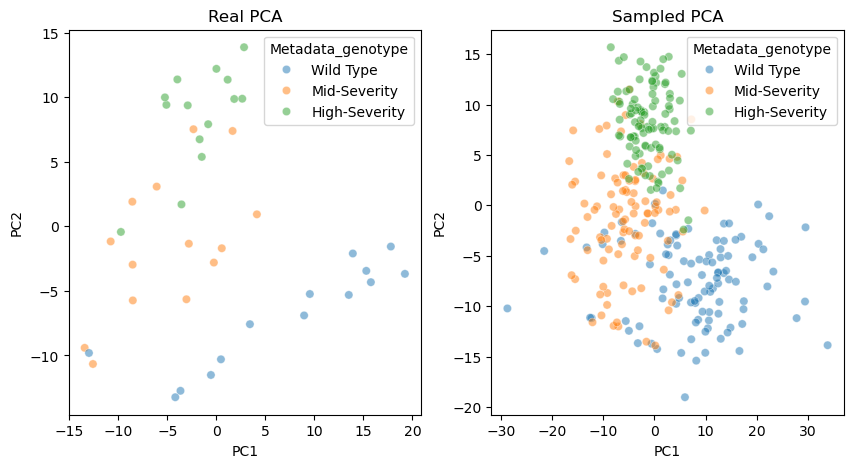

In [16]:
# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=custom_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()